# Geolocation Analysis of Transactions

Goal: Analyze spatial patterns of fraud transactions, detect randomness, and engineer useful location features

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
PROCESSED_DATA = Path("../data/processed/")
FIGURES_DATA = Path("../reports/figures/")

In [4]:
df = pd.read_parquet(PROCESSED_DATA / "transactions.parquet")

df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,1,145,0,0
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,1,32,1,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,1,604,1,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,0,1031,1,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,1,330,0,0


In [5]:
df_location = pd.json_normalize(df['location'])

In [6]:
df_location.head()

,lat,long
0,40.057938,14.959737
1,42.059350,1.596625
2,50.923432,21.795262
3,56.833396,-9.881566
4,54.042996,2.168516


In [7]:
df = pd.concat([df.drop(columns=['location']), df_location], axis=1)

In [8]:
print("Latitude range:", df["lat"].min(), df["lat"].max())
print("Longitude range:", df["long"].min(), df["long"].max())

Latitude range: 35.000013 69.999823
Longitude range: -9.999975 39.999761


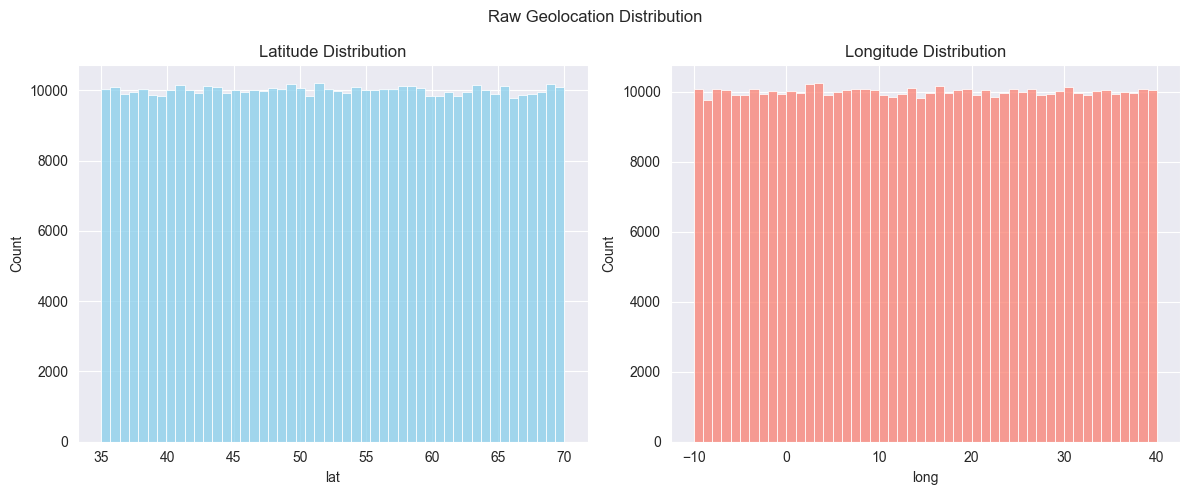

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["lat"], bins=50, ax=ax[0], color="skyblue")
ax[0].set_title("Latitude Distribution")

sns.histplot(df["long"], bins=50, ax=ax[1], color="salmon")
ax[1].set_title("Longitude Distribution")

plt.suptitle("Raw Geolocation Distribution")

fig.tight_layout()
plt.show()

fig.tight_layout()
plt.show()

In [13]:
label_map = {0: "Legitimate", 1: "Fraudulent"}
df_sampled = df.sample(10000, random_state=42).copy()
df_sampled["fraud_label"] = df_sampled["is_fraud"].map(label_map)

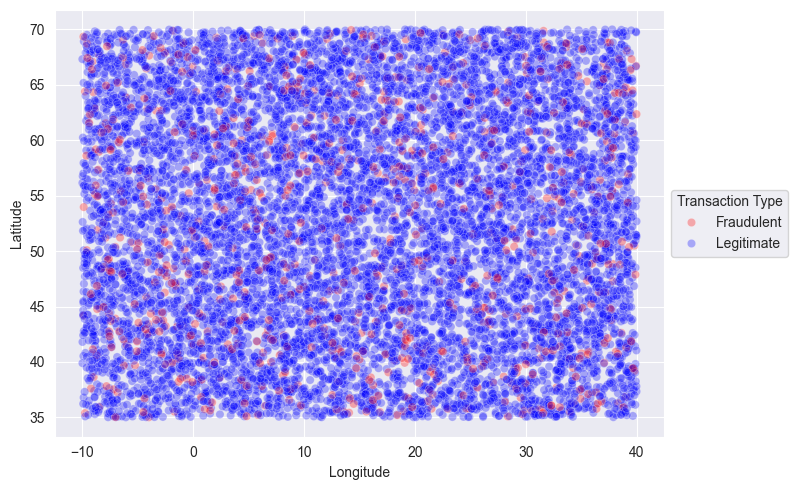

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.scatterplot(
	data=df_sampled,
	ax=ax,
	x="long",
	y="lat",
	hue="fraud_label",
	alpha=0.3,
	palette={"Legitimate": "blue", "Fraudulent": "red"}
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_aspect("equal")

ax.legend(title="Transaction Type", loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.savefig(FIGURES_DATA / "transactions_locations_sampled.png")
plt.show()

In [25]:
fig = px.scatter_map(
	df_sampled.sample(5000, random_state=42),
	lat="lat",
	lon="long",
	color="fraud_label",
	hover_data=["is_fraud"],
	zoom=3,
	height=650,
	color_continuous_scale={"Legitimate": "rgba(0,0,255,0.3)", "Fraudulent": "red"}
)

# Saving to PNG doesn't work on ARM Silicon, save as HTML instead and take a screenshot from the HTML."
fig.write_html(FIGURES_DATA / "transactions_locations_sampled_map.html")
fig.show()